# Analysez les ventes d'une librairie avec Python

### Table des matières

* [Import des fichiers csv](#Import_des_fichiers_csv)
* [Nettoyage des données](#Nettoyage_des_données)
    * [Vérification du type des variables](#Type_des_variables)
    * [Vérification des doublons](#Doublons)
    * [Détection des valeurs manquantes ou nulles](#valeurs_manquantes)
    * [Jointure des fichiers](#jointure_fichiers)
    
* [1. Chiffre d'affaire de la librairie](#ca_librairie)
    * [Analyse sur le chiffre d'affaire en fonction du temps](#ca_temps)
    * [Analyse sur les références proposées et les catégories](#ca_references)
    * [Répartition du chiffre d'affaire par catégorie](#ca_categ)
    * [CA par client (et courbe de Lorenz)](#ca_client)
    * [Analyse sur le genre des clients](#ca_genre) 
    * [Analyse sur l'âge des clients](#ca_age) 
    
* [2. Correlation entre 2 variables : tests statistiques](#stats)
    * [Genre et catégorie](#genre_categ) : Khi2 et test V de Cramer
    * [Age des clients et montant total](#age_montant_total) : tests de Spearman et Pearson
    * [Tranche d'âge des clients et montant total](#tranche_age_montant_total) : Anova et test de Kruskal-Wallis
    * [Panier moyen par âge](#age_panier_moyen) : tests de Spearman et Pearson
    * [Panier moyen par tranche d'âge](#tranche_age_panier_moyen) : Anova et test de Kruskal-Wallis
    * [Age des clients et fréquence d'achat](#age_frequence_achat) : tests de Spearman et Pearson
    * [Tranche d'âge des clients et fréquence d'achat](#tranche_age_frequence_achat) : Anova et test de Kruskal-Wallis
    * [Catégorie des livres achetés par tranche d'âge](#tranche_age_categ) : Khi2 et test V de Cramer
    * [Catégorie des livres achetés par âge](#age_categ) : Anova et test de Kruskal-Wallis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

### Import des fichiers csv<a class="anchor" id="Import_des_fichiers_csv"></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
customers = pd.read_csv('customers.csv')
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [4]:
products = pd.read_csv('products.csv')
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [5]:
transactions = pd.read_csv('transactions.csv')
transactions

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


### Nettoyage des données <a class="anchor" id="Nettoyage_des_données"></a>

#### Vérification du type des variables <a class="anchor" id="type_des_variables"></a>

In [6]:
#Je vérifie les types des variables pour chaque fichier
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [7]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [8]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [9]:
#Je corrige le format de la date en enlevant les 7 derniers caractères
transactions['date']=transactions['date'].str[:-15]
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20,s_211425,c_103
1,1_251,2022-02-02,s_158752,c_8534
2,0_1277,2022-06-18,s_225667,c_6714
3,2_209,2021-06-24,s_52962,c_6941
4,0_1509,2023-01-11,s_325227,c_4232


In [10]:
#Je convertis la date au format date
transactions['date'] = pd.to_datetime(transactions['date'], errors = 'coerce')

In [11]:
transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

#### Vérification des doublons<a class="anchor" id="Doublons"></a>

In [12]:
#Je vérifie les doublons du fichier transactions

transactions.loc[transactions[['id_prod', 'date', 'session_id', 'client_id']].duplicated(keep=False),:]

,id_prod,date,session_id,client_id
582,0_1123,2021-04-29,s_27641,c_4459
889,0_1335,2023-02-01,s_335537,c_4561
1193,0_1424,2021-03-20,s_8842,c_4595
1278,1_397,2022-05-17,s_209799,c_915
1292,0_1361,2022-04-24,s_198937,c_1784
...,...,...,...,...
677618,0_1561,2021-06-21,s_51611,c_8596
678160,0_2267,2021-04-01,s_14298,c_7526
679180,T_0,NaT,s_0,ct_1
679356,1_459,2021-12-14,s_134184,c_120


In [13]:
#Je supprime les doublons du fichier transactions

transactions.drop_duplicates(subset=['id_prod', 'date', 'session_id', 'client_id'], inplace=True, ignore_index=True)
transactions

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20,s_211425,c_103
1,1_251,2022-02-02,s_158752,c_8534
2,0_1277,2022-06-18,s_225667,c_6714
3,2_209,2021-06-24,s_52962,c_6941
4,0_1509,2023-01-11,s_325227,c_4232
...,...,...,...,...
678509,0_1551,2022-01-15,s_150195,c_8489
678510,1_639,2022-03-19,s_181434,c_4370
678511,0_1425,2022-12-20,s_314704,c_304
678512,0_1994,2021-07-16,s_63204,c_2227


+ Je vérifie les doublons des deux autres fichiers

In [14]:
customers.loc[customers[['client_id','sex','birth']].duplicated(keep=False),:]

,client_id,sex,birth


In [15]:
products.loc[products[['id_prod','price','categ']].duplicated(keep=False),:]

,id_prod,price,categ


#### Je vérifie si les jeux de données contiennent des valeurs nulles ou manquantes<a class="anchor" id="valeurs_manquantes"></a> 

In [16]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [17]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [18]:
transactions.isnull().sum()

id_prod       0
date          2
session_id    0
client_id     0
dtype: int64

In [19]:
#J'affiche les 2 lignes comprenant des NaT sur la variable date du fichier transactions
transactions.loc[transactions['date'].isnull(),:]

,id_prod,date,session_id,client_id
3019,T_0,NaT,s_0,ct_0
9666,T_0,NaT,s_0,ct_1


In [20]:
# Je supprime ces 2 lignes qui ne présentent pas d'intêret
transactions = transactions.dropna(subset=['date'])

In [21]:
# Je vérifie leur bonne suppression
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

#### Jointure des fichiers<a class="anchor" id="jointure_fichiers"></a> 

In [22]:
# Je joins mes fichiers customers et transactions.
# J'effectue une jointure à droite afin de conserver l'ensemble des transactions.

customers_transactions = pd.merge(customers,transactions,on = 'client_id', how = 'right')
customers_transactions

,client_id,sex,birth,id_prod,date,session_id
0,c_103,f,1986,0_1518,2022-05-20,s_211425
1,c_8534,m,1988,1_251,2022-02-02,s_158752
2,c_6714,f,1968,0_1277,2022-06-18,s_225667
3,c_6941,m,2000,2_209,2021-06-24,s_52962
4,c_4232,m,1980,0_1509,2023-01-11,s_325227
...,...,...,...,...,...,...
678507,c_8489,f,1951,0_1551,2022-01-15,s_150195
678508,c_4370,f,1977,1_639,2022-03-19,s_181434
678509,c_304,f,1988,0_1425,2022-12-20,s_314704
678510,c_2227,m,1986,0_1994,2021-07-16,s_63204


In [23]:
# Je joins le dataframe obtenu au fichier products afin d'obtenir mon fichier_global.
# Je choisi d'effectuer une jointure à gauche, toujours pour conserver l'ensemble des transactions.

fichier_global = pd.merge(customers_transactions, products, on = 'id_prod', how = 'left')
fichier_global

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_103,f,1986,0_1518,2022-05-20,s_211425,4.18,0.0
1,c_8534,m,1988,1_251,2022-02-02,s_158752,15.99,1.0
2,c_6714,f,1968,0_1277,2022-06-18,s_225667,7.99,0.0
3,c_6941,m,2000,2_209,2021-06-24,s_52962,69.99,2.0
4,c_4232,m,1980,0_1509,2023-01-11,s_325227,4.99,0.0
...,...,...,...,...,...,...,...,...
678507,c_8489,f,1951,0_1551,2022-01-15,s_150195,12.99,0.0
678508,c_4370,f,1977,1_639,2022-03-19,s_181434,10.99,1.0
678509,c_304,f,1988,0_1425,2022-12-20,s_314704,12.99,0.0
678510,c_2227,m,1986,0_1994,2021-07-16,s_63204,4.98,0.0


In [24]:
# Je vérifie si j'ai des valeurs manquantes ou nulles sur les variables du fichier global.

fichier_global.isnull().sum()

client_id       0
sex             0
birth           0
id_prod         0
date            0
session_id      0
price         221
categ         221
dtype: int64

In [25]:
# J'identifie les lignes concernées et je constate que le produit 0_2245 n'a ni prix, ni catégorie assignée. 

fichier_global.loc[fichier_global['price'].isnull(),:]

,client_id,sex,birth,id_prod,date,session_id,price,categ
2633,c_4746,m,1940,0_2245,2022-09-23,s_272266,NaN,NaN
10102,c_6713,f,1963,0_2245,2022-07-23,s_242482,NaN,NaN
11722,c_5108,m,1978,0_2245,2022-12-03,s_306338,NaN,NaN
15669,c_1391,m,1991,0_2245,2021-08-16,s_76493,NaN,NaN
16371,c_7954,m,1973,0_2245,2022-07-16,s_239078,NaN,NaN
...,...,...,...,...,...,...,...,...
668737,c_131,m,1981,0_2245,2021-08-25,s_80395,NaN,NaN
669686,c_4167,f,1979,0_2245,2022-03-06,s_175311,NaN,NaN
670288,c_4453,m,1981,0_2245,2022-05-16,s_209381,NaN,NaN
674668,c_1098,m,1986,0_2245,2022-02-11,s_163405,NaN,NaN


In [26]:
# Je vérifie que j'ai bien 221 transactions pour l'id_prod 0_2245

fichier_global.loc[fichier_global['id_prod'] == '0_2245'].count()

client_id     221
sex           221
birth         221
id_prod       221
date          221
session_id    221
price           0
categ           0
dtype: int64

In [27]:
# Etant donné que l'identifiant débute par 0, il s'agit de la catégorie 0. 
# Je peux donc assigner la catégorie 0 à l'id_prod 0_2245

fichier_global.loc[fichier_global['categ'].isnull(), 'categ'] = '0'

In [28]:
# En ce qui concerne le prix, je vais lui assigner le prix correspondant à la moyenne des prix des livres de catégorie 0

round(fichier_global.groupby(['categ'])['price'].mean(),2)

categ
0.0    10.64
1.0    20.49
2.0    76.23
0        NaN
Name: price, dtype: float64

In [29]:
fichier_global.loc[fichier_global['price'].isnull(), 'price'] = '10.64'

In [30]:
# Je vérifie l'absence de valeurs nulle ou manquante. 

fichier_global.isnull().sum()

client_id     0
sex           0
birth         0
id_prod       0
date          0
session_id    0
price         0
categ         0
dtype: int64

In [31]:
fichier_global.dtypes

client_id             object
sex                   object
birth                  int64
id_prod               object
date          datetime64[ns]
session_id            object
price                 object
categ                 object
dtype: object

In [32]:
# Je convertis le format des variables 'price' et 'categ'

fichier_global['price'] = pd.to_numeric(fichier_global['price'], errors = 'coerce')
fichier_global['categ'] = pd.to_numeric(fichier_global['categ'], errors = 'coerce')

In [33]:
# Je renomme ma variable 'price' en 'ca' pour éviter toute confusion. Chaque prix indiqué correspond à une vente. 

fichier_global.rename(columns = {'price': 'ca'}, inplace=True)
fichier_global.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ
0,c_103,f,1986,0_1518,2022-05-20,s_211425,4.18,0.0
1,c_8534,m,1988,1_251,2022-02-02,s_158752,15.99,1.0
2,c_6714,f,1968,0_1277,2022-06-18,s_225667,7.99,0.0
3,c_6941,m,2000,2_209,2021-06-24,s_52962,69.99,2.0
4,c_4232,m,1980,0_1509,2023-01-11,s_325227,4.99,0.0


### 1. Chiffre d'affaire de la librairie<a class="anchor" id="ca_librairie"></a>

#### Analyse sur le chiffre d'affaire en fonction du temps<a class="anchor" id="ca_temps"></a>

In [34]:
# Commençons par calculer le chiffre d'affaire total

ca_global = round(fichier_global['ca'].sum(),2)
print("le chiffre d'affaire global est de",ca_global,"€")

le chiffre d'affaire global est de 11838950.11 €


+ Regardons à quels moments du mois les clients achètent le plus avec la création d'une variable quart_mois.

In [35]:
# Ajout d'une colonne année

fichier_global['annee'] = fichier_global['date'].dt.year 

In [36]:
# Ajout d'une colonne mois

fichier_global['mois'] = fichier_global['date'].dt.month

In [37]:
# Ajout d'une colonne jour

fichier_global['jour'] = fichier_global['date'].dt.day

In [38]:
# Tri du fichier selon la date d'achat

fichier_global = fichier_global.sort_values(by='date')
fichier_global.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour
400775,c_1769,m,1996,1_468,2021-03-01,s_125,17.75,1.0,2021,3,1
476277,c_3779,f,1990,0_1448,2021-03-01,s_382,18.94,0.0,2021,3,1
47281,c_2505,f,1982,0_1571,2021-03-01,s_12,5.99,0.0,2021,3,1
237001,c_5212,f,1979,0_1583,2021-03-01,s_246,15.99,0.0,2021,3,1
174982,c_4730,m,1955,1_286,2021-03-01,s_265,29.44,1.0,2021,3,1


In [39]:
fichier_global['quart_mois'] = [int((jour-1)*4/31)+1 for jour in fichier_global["date"].dt.day]

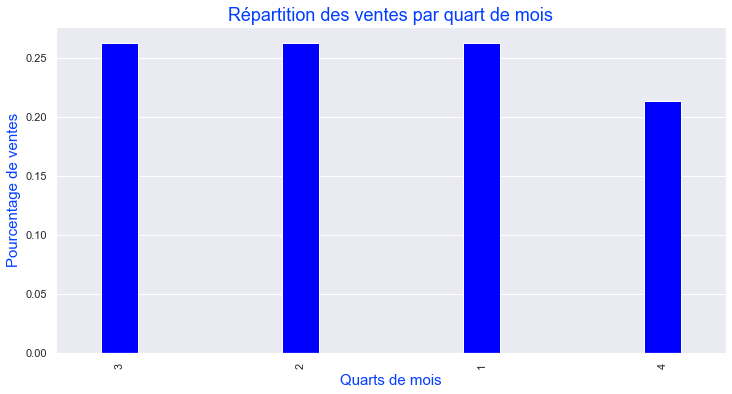

In [130]:
fichier_global["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.2,color='blue',figsize = (12,6))
plt.grid(axis='x')
plt.title("Répartition des ventes par quart de mois",fontsize=18,color='b')
plt.xlabel("Quarts de mois",fontsize=15,color='b')
plt.ylabel("Pourcentage de ventes",fontsize=15,color='b')
plt.show()

>On se rend compte que les clients achètent moins en fin de mois => c'est peut-être le moment de faire des promotions. 

+ Chiffre d'affaire en fonction du jour

In [41]:
# Je regarde la répartition du chiffre d'affaire en fonction du jour.

ca_jour = fichier_global.groupby(['jour'])['ca'].sum().reset_index()
ca_jour['moyenne_mobile'] = round(ca_jour['ca'].rolling(3).mean(),2)
ca_jour.head()

,jour,ca,moyenne_mobile
0,1,392934.71,NaN
1,2,393750.75,NaN
2,3,379569.89,388751.78
3,4,380425.68,384582.11
4,5,392041.31,384012.29


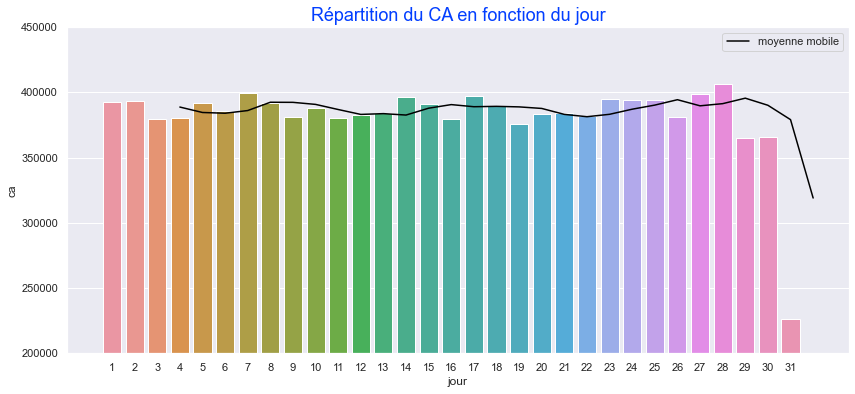

In [131]:
plt.figure(figsize = (14,6))
plt.title("Répartition du CA en fonction du jour", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
plt.ylim(200000, 450000)
plt.ylabel("Chiffre d'affaire")
sns.barplot(data=ca_jour, x="jour", y="ca")
sns.lineplot(data=ca_jour, x="jour", y="moyenne_mobile", color = 'black',label='moyenne mobile')
plt.show()

>On retrouve la baisse de chiffre d'affaire en fin de mois.

In [43]:
# Je passe maintenant le format de la date à un format aaaa-mm.

fichier_global['date'] = pd.to_datetime(fichier_global['date']).dt.strftime('%Y-%m')
fichier_global.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois
400775,c_1769,m,1996,1_468,2021-03,s_125,17.75,1.0,2021,3,1,1
476277,c_3779,f,1990,0_1448,2021-03,s_382,18.94,0.0,2021,3,1,1
47281,c_2505,f,1982,0_1571,2021-03,s_12,5.99,0.0,2021,3,1,1
237001,c_5212,f,1979,0_1583,2021-03,s_246,15.99,0.0,2021,3,1,1
174982,c_4730,m,1955,1_286,2021-03,s_265,29.44,1.0,2021,3,1,1


+ Regardons maintenant comment évolue le ca entre la première année et la seconde année

In [44]:
ca_premiere_annee = fichier_global.loc[fichier_global['date'] < '2022-03']
ca_premiere_annee.sort_values(['date']).head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois
400775,c_1769,m,1996,1_468,2021-03,s_125,17.75,1.0,2021,3,1,1
448639,c_7353,m,1987,0_2021,2021-03,s_9585,12.99,0.0,2021,3,21,3
107026,c_1181,m,2002,2_236,2021-03,s_9258,118.51,2.0,2021,3,21,3
157125,c_4622,m,1959,1_392,2021-03,s_9631,18.11,1.0,2021,3,21,3
9034,c_8078,m,1978,0_1292,2021-03,s_9309,9.80,0.0,2021,3,21,3


In [45]:
ca_premiere_annee['ca'].describe()

count    336884.000000
mean         17.290225
std          18.164509
min           0.620000
25%           8.580000
50%          13.900000
75%          18.990000
max         300.000000
Name: ca, dtype: float64

In [46]:
ca_1 = round(ca_premiere_annee['ca'].sum(),2)
print("le chiffre d'affaire de la première année est de",ca_1,"€")

le chiffre d'affaire de la première année est de 5824800.25 €


In [47]:
ca_deuxieme_annee = fichier_global.loc[fichier_global['date'].between('2022-03','2023-02')]
ca_deuxieme_annee.sort_values(['date']).head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois
216692,c_1515,m,1972,0_1157,2022-03,s_172643,18.99,0.0,2022,3,1,1
176408,c_295,m,1983,0_1446,2022-03,s_182761,8.09,0.0,2022,3,22,3
327526,c_5270,m,1981,1_506,2022-03,s_182990,13.65,1.0,2022,3,22,3
558657,c_4545,f,1986,0_1078,2022-03,s_182650,6.92,0.0,2022,3,22,3
415859,c_7740,f,1975,0_2301,2022-03,s_182952,4.99,0.0,2022,3,22,3


In [48]:
ca_deuxieme_annee['ca'].describe()

count    341628.000000
mean         17.604382
std          18.473703
min           0.620000
25%           8.990000
50%          13.990000
75%          19.080000
max         300.000000
Name: ca, dtype: float64

In [49]:
ca_2 = round(ca_deuxieme_annee['ca'].sum(),2)
print("le chiffre d'affaire de la deuxième année est de",ca_2,"€")

le chiffre d'affaire de la deuxième année est de 6014149.86 €


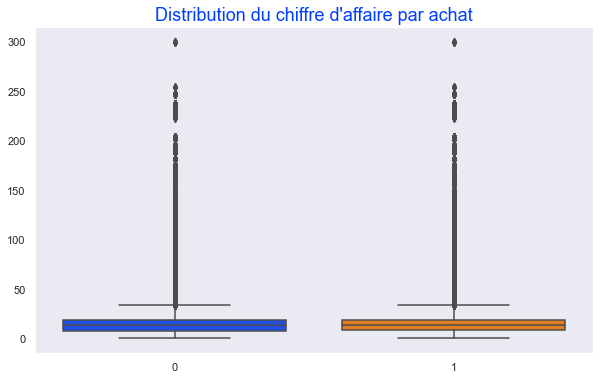

In [50]:
# Distribution du chiffre d'affaire par achat entre la première et la deuxième année

plt.figure(figsize = (10,6))
plt.grid(axis='y')
plt.title("Distribution du chiffre d'affaire par achat", fontsize=18,color='b')
sns.set_theme(style="ticks", palette="bright")
data = [ca_premiere_annee['ca'], ca_deuxieme_annee['ca']]
sns.boxplot(data=data)
plt.show()

>On constate des distributions de chiffre d'affaire par achat très similaires entre les deux années. 

+ Evolution du chiffre d'affaire entre la première et la deuxième année

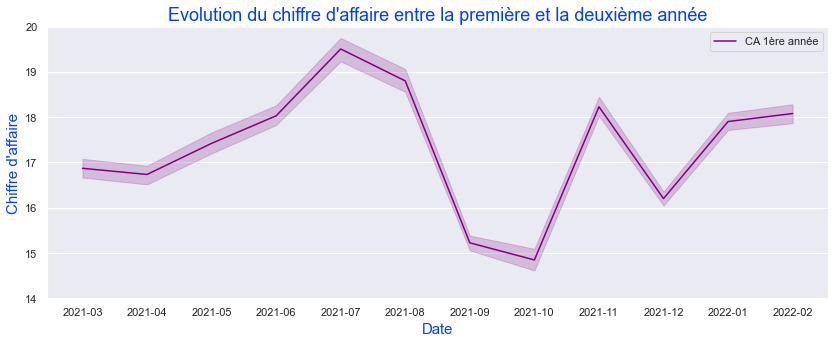

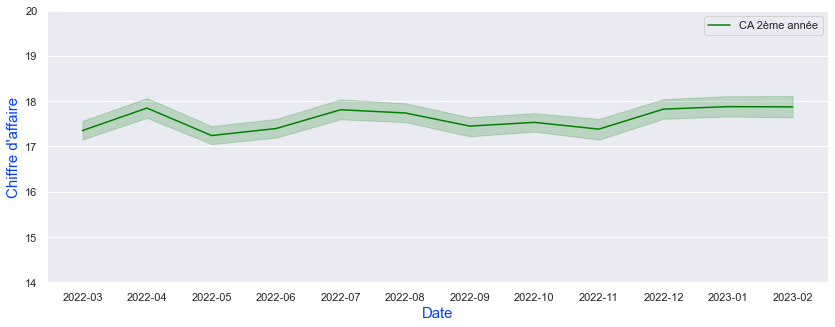

In [132]:
plt.figure(figsize = (14,5))
plt.title("Evolution du chiffre d'affaire entre la première et la deuxième année", fontsize=18,color='b')
plt.xlabel('Date',  fontsize=15, color='b')
plt.ylabel("Chiffre d'affaire",  fontsize=15, color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
plt.ylim(14,20)
sns.lineplot(data=ca_premiere_annee, x="date", y="ca", label="CA 1ère année",color="purple")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize = (14,5))
plt.xlabel('Date',  fontsize=15, color='b')
plt.ylabel("Chiffre d'affaire",  fontsize=15, color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
plt.ylim(14,20)
sns.lineplot(data=ca_deuxieme_annee, x="date", y="ca", label="CA 2ème année",color="green")
plt.legend(loc="upper right")
plt.show()

In [52]:
ca_total = {'année':['annee_1', 'annee_2'], 'ca_t':[ca_1, ca_2]}
ca_1_2 = pd.DataFrame(ca_total)
ca_1_2

,année,ca_t
0,annee_1,5824800.25
1,annee_2,6014149.86


In [53]:
evolution_ca = round((ca_2 - ca_1) / ca_1 * 100,2)
print("Entre la première et la deuxième année d'activité, le chiffre d'affaire à augmenté de",evolution_ca,"%")

Entre la première et la deuxième année d'activité, le chiffre d'affaire à augmenté de 3.25 %


+ Décomposition du CA mensuel en moyenne mobile

In [54]:
# Je calcule pour chaque mois, la moyenne du chiffre d'affaire par client.

ca_mois = round(fichier_global.groupby(['date'])['ca'].mean().reset_index(),2)
ca_mois.head()

,date,ca
0,2021-03,16.87
1,2021-04,16.73
2,2021-05,17.42
3,2021-06,18.03
4,2021-07,19.50


In [55]:
# J'ajoute une colonne 'moyenne mobile'

ca_mois['moyenne_mobile'] = round(ca_mois['ca'].rolling(3).mean(),2)
ca_mois.head(10)

,date,ca,moyenne_mobile
0,2021-03,16.87,NaN
1,2021-04,16.73,NaN
2,2021-05,17.42,17.01
3,2021-06,18.03,17.39
4,2021-07,19.50,18.32
5,2021-08,18.80,18.78
6,2021-09,15.22,17.84
7,2021-10,14.85,16.29
8,2021-11,18.23,16.10
9,2021-12,16.20,16.43


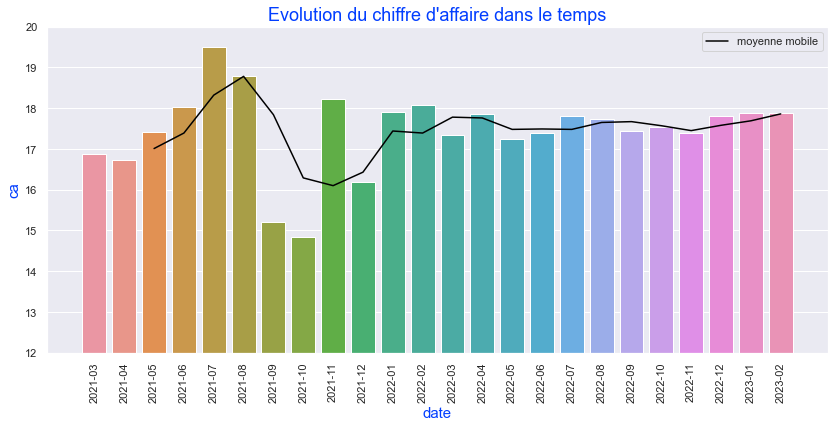

In [56]:
plt.figure(figsize = (14,6))
plt.title("Evolution du chiffre d'affaire dans le temps", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.xlabel('Date',  fontsize=15, color='b')
plt.ylabel("Chiffre d'affaire",  fontsize=15, color='b')
plt.grid(axis='x')
plt.ylim(12.0, 20.0)
plt.xticks(rotation = 'vertical')
sns.barplot(data=ca_mois, x="date", y="ca")
sns.lineplot(data=ca_mois, x="date", y="moyenne_mobile", color = 'black',label='moyenne mobile')
plt.show()

>Après un chiffre d'affaire exceptionnellement haut en juillet 2021, on constate une grosse chute du chiffre d'affaire en septembre et octobre 2021.

Vérifions donc les catégories vendues en septembre et en octobre 2021.

In [57]:
ca_premiere_annee.pivot_table(index='mois',columns='categ',values='ca',aggfunc='sum')

categ,0.0,1.0,2.0
mois,,,
1,164148.41,255855.84,104805.69
2,183096.06,212765.47,138586.54
3,193500.67,186747.68,101837.27
4,205076.27,155998.12,114485.15
5,196005.89,165772.39,130500.41
6,167763.87,188935.56,126841.08
7,144622.74,188284.98,148976.06
8,167649.55,162897.67,151369.24
9,246244.53,190434.54,70204.00


Regardons maintenant plus en détail le mois d'octobre 2021 (on constate une grosse baisse du ca pour la catégorie 1)

In [58]:
ca_octobre_2021 = ca_premiere_annee.loc[ca_premiere_annee['date']=='2021-10',:]
ca_octobre_2021.pivot_table(index='jour',columns='categ',values='ca',aggfunc='sum')

categ,0.0,1.0,2.0
jour,,,
1,6950.50,6989.80,3036.48
2,7121.09,NaN,2041.12
3,6786.57,NaN,2206.48
4,6554.88,NaN,2746.08
5,6326.88,NaN,3032.55
6,7521.60,NaN,1944.11
7,6398.55,NaN,1787.07
8,7040.55,NaN,3137.82
9,6808.69,NaN,2616.67


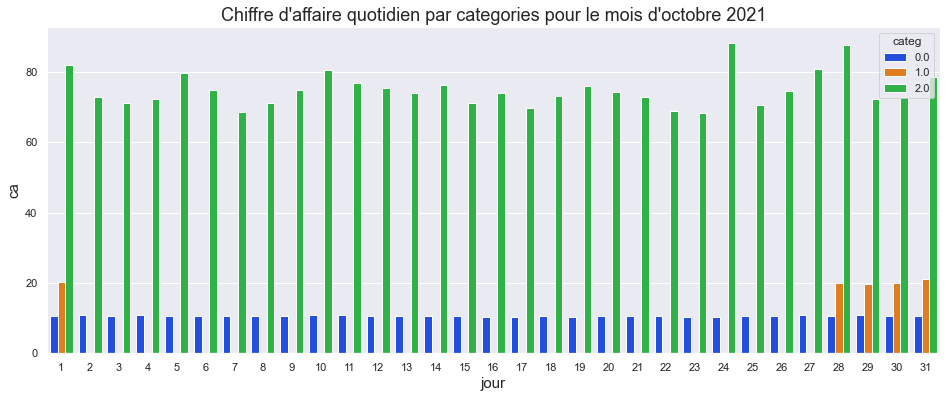

In [59]:
plt.figure(figsize = (16,6))
plt.title("Chiffre d'affaire quotidien par categories pour le mois d'octobre 2021", fontsize=18)
sns.set_theme(palette="bright")
plt.grid(axis='x')
plt.ylabel("Chiffre d'affaire",fontsize=15)
plt.xlabel("jours du mois d'octobre 2021",fontsize=15)
sns.barplot(data=ca_octobre_2021,x='jour',y='ca',hue='categ',ci = None)
plt.show()

>Nous pouvons constater qu'aucune vente n'est enregistrée sur la période du 2 au 27 octobre 2021 pour les livres de 1ère catégorie. 
Il s'agit visiblement d'un problème informatique. Les autres catégories ont été vendues normalement. 

>Nous allons donc créer un sous-échantillon dans lequel nous enleverons le mois d'octobre 2021 afin de ne pas fausser les analyses suivantes. 

In [60]:
# On retire octobre 2021

fichier_global_sans_octobre = fichier_global.loc[fichier_global["date"] != 2021-10, :]

#### Analyse sur les références proposées et les catégories<a class="anchor" id="ca_references"></a>

In [61]:
# Regardons le nombre de références vendues

nb_references = fichier_global_sans_octobre['id_prod'].count()
print("Depuis l'ouverture du site de vente en ligne, la librairie a vendu",nb_references,"références.")

Depuis l'ouverture du site de vente en ligne, la librairie a vendu 678512 références.


In [62]:
# Chiffre d'affaire généré par les références qui se vendent le mieux

references = round(fichier_global_sans_octobre.groupby(['id_prod','categ'])['ca'].sum(),2).reset_index()
references.sort_values(['ca'],ascending=False).head(10)

,id_prod,categ,ca
3097,2_159,2.0,94747.51
3071,2_135,2.0,68576.06
3046,2_112,2.0,64867.20
3035,2_102,2.0,60618.50
3153,2_209,2.0,56971.86
2620,1_395,1.0,54298.27
2592,1_369,1.0,53857.55
3044,2_110,2.0,53846.25
3202,2_39,2.0,53060.85
3105,2_166,2.0,52449.12


In [63]:
# Et le chiffre d'affaire de celles qui se vendent le moins bien

references.sort_values(['ca']).head(10)

,id_prod,categ,ca
595,0_1539,0.0,0.99
313,0_1284,0.0,1.38
719,0_1653,0.0,1.98
1785,0_541,0.0,1.99
2080,0_807,0.0,1.99
665,0_1601,0.0,1.99
802,0_1728,0.0,2.27
549,0_1498,0.0,2.48
2180,0_898,0.0,2.54
925,0_1840,0.0,2.56


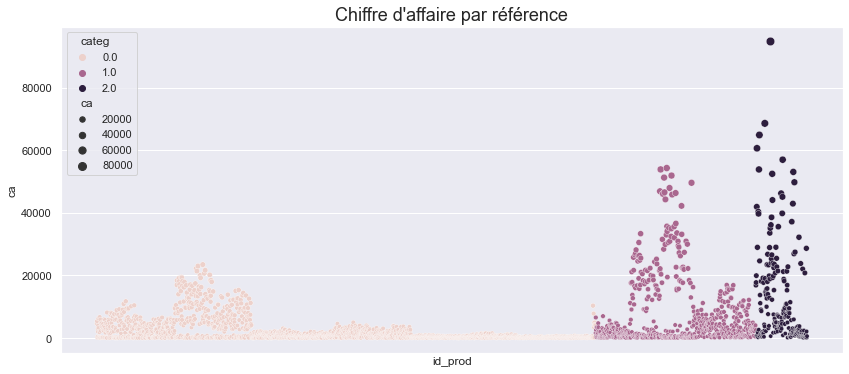

In [64]:
# Tentons une représentation graphique du CA par référence

plt.figure(figsize = (14,6))
plt.title("Chiffre d'affaire par référence", fontsize=18)
plt.xticks([])
plt.xlabel("id_prod")
sns.set_theme(style="darkgrid", palette="bright")
sns.scatterplot(data=references, x="id_prod",y="ca", hue="categ", marker="o", size='ca')
plt.show()

#### Répartition du chiffre d'affaire par catégorie<a class="anchor" id="ca_categ"></a>

In [65]:
# Répartition du chiffre d'affaire par catégorie

categories = round(fichier_global_sans_octobre.groupby(['categ'])['ca'].sum(),2)
categories

categ
0.0    4417128.91
1.0    4648137.82
2.0    2773683.38
Name: ca, dtype: float64

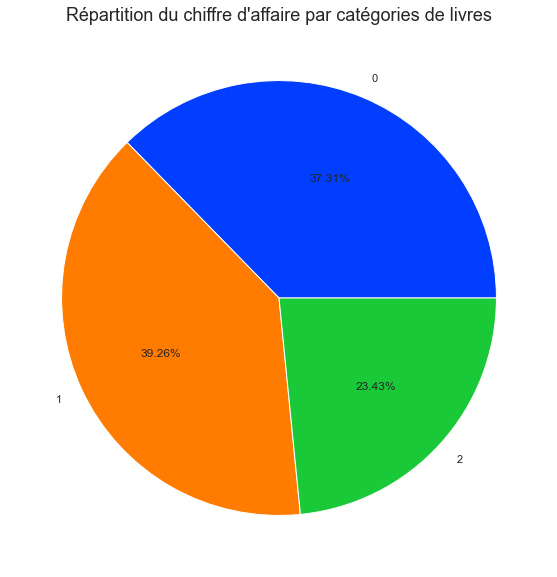

In [66]:
plt.figure(figsize = (10,10))
plt.title("Répartition du chiffre d'affaire par catégories de livres", fontsize=18)
sns.set_theme(palette="bright")
plt.pie( x=categories, labels = ['0','1','2'],autopct='%.2f%%')
plt.show()

+ Nombre de ventes par catégorie de livres

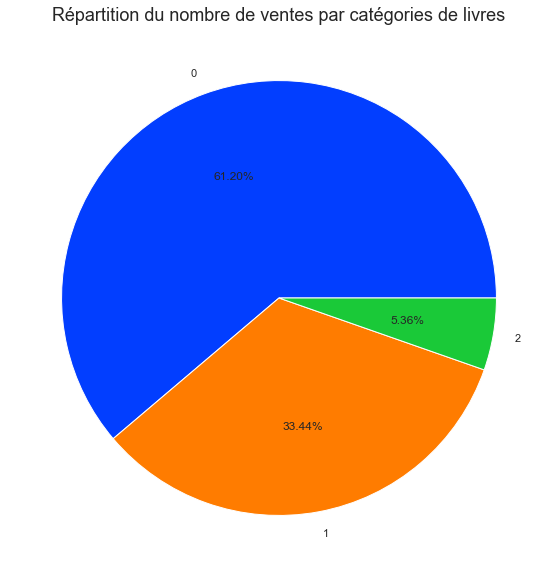

In [67]:
nb_par_categ = fichier_global_sans_octobre['categ'].value_counts()

plt.figure(figsize = (10,10))
plt.title("Répartition du nombre de ventes par catégories de livres", fontsize=18)
sns.set_theme(palette="bright")
plt.pie(x= nb_par_categ , labels = ['0','1','2'],autopct='%.2f%%')
plt.show()

+ Moyenne des prix des livres pour chaque catégorie

In [68]:
ca_moyen_categ = round(fichier_global_sans_octobre.groupby(['categ'])['ca'].mean(),2).reset_index()
ca_moyen_categ 

,categ,ca
0,0.0,10.64
1,1.0,20.49
2,2.0,76.23


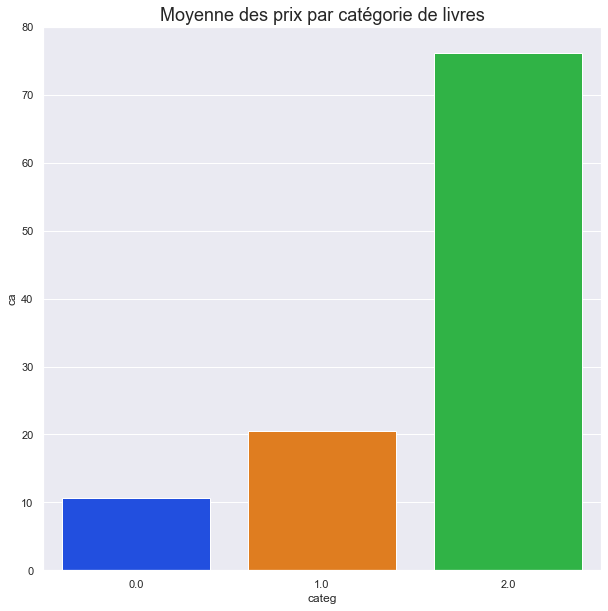

In [69]:
plt.figure(figsize = (10,10))
plt.title("Moyenne des prix par catégorie de livres", fontsize=18)
sns.set_theme(style="darkgrid", palette="bright")
sns.barplot(data = ca_moyen_categ, x = 'categ', y = 'ca')
plt.show()

>La moyenne des prix pour chaque catégorie, peut nous permettre d'interpreter le type de livres qui composent cette catégorie : 

>+ Catégorie 0 : Livres de poche
>+ Catégorie 1 : Romans
>+ Catégorie 2 : Beaux livres

>D'autre part, malgré des prix de vente moins élevés, le CA généré pour les catégories 0 et 1 est plus important que celui généré par les livres de catégorie 2. En effet, quand on regarde les pourcentages de vente pour chaque catégorie, on comprend l'impact sur le chiffre d'affaire.

#### Regardons maintenant le CA par client <a class="anchor" id="ca_client"></a>

In [70]:
ca_par_client = fichier_global_sans_octobre.groupby(['client_id'])['ca'].sum().reset_index()
ca_par_client.sort_values('ca', ascending = False).head(10)

,client_id,ca
677,c_1609,323678.54
4388,c_4958,288600.82
6337,c_6714,153434.44
2724,c_3454,113669.85
2513,c_3263,5276.87
634,c_1570,5271.62
2108,c_2899,5214.05
1268,c_2140,5208.82
7006,c_7319,5155.77
7791,c_8026,5093.22


> On constate que 4 gros clients se détachent du reste des clients. Au vu des montants, il s'agit sans doute de clients professionnels. 

In [71]:
# Je crée une liste avec les identifiants des clients professionnels

clients_pro = ['c_1609','c_4958','c_6714','c_3454']

# Puis je crée un dataframe composé uniquement des lignes se rapportant à ces 4 clients

fichier_global_pro = fichier_global_sans_octobre.loc[fichier_global_sans_octobre['client_id'].isin(clients_pro)] 
fichier_global_pro.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois
582924,c_4958,m,1999,2_150,2021-03,s_165,157.63,2.0,2021,3,1,1
170208,c_3454,m,1969,1_376,2021-03,s_89,17.49,1.0,2021,3,1,1
576334,c_3454,m,1969,1_413,2021-03,s_228,17.99,1.0,2021,3,1,1
447117,c_6714,f,1968,0_1410,2021-03,s_145,14.85,0.0,2021,3,1,1
526429,c_6714,f,1968,0_1471,2021-03,s_310,12.99,0.0,2021,3,1,1


In [72]:
# Regardons si la répartition des ventes selon la catégorie de livres achetée est la même que pour l'ensemble des clients

nb_par_categ_pro = fichier_global_pro['categ'].value_counts()
nb_par_categ_pro

0.0    28165
1.0    14807
2.0     3624
Name: categ, dtype: int64

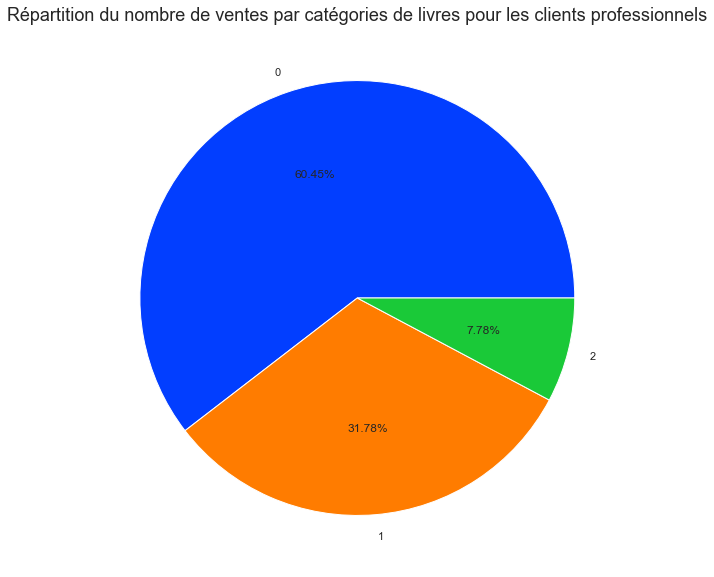

In [73]:
plt.figure(figsize = (10,10))
plt.title("Répartition du nombre de ventes par catégories de livres pour les clients professionnels", fontsize=18)
sns.set_theme(palette="bright")
plt.pie(x= nb_par_categ_pro , labels = ['0','1','2'],autopct='%.2f%%')
plt.show()

> La répartition des ventes par catégorie de livres pour les professionnels, suit à peu près la même répartition entre chaque catégorie que pour l'ensemble des clients mais ne va concerner que 4 clients. Pour ne pas fausser les analyses suivantes, nous allons donc ne garder pour la suite du projet que les clients particuliers. 

In [74]:
# On ne garde que les clients particuliers

fichier_global_part = fichier_global_sans_octobre.loc[~fichier_global_sans_octobre['client_id'].isin(clients_pro)] 
fichier_global_part.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois
400775,c_1769,m,1996,1_468,2021-03,s_125,17.75,1.0,2021,3,1,1
476277,c_3779,f,1990,0_1448,2021-03,s_382,18.94,0.0,2021,3,1,1
47281,c_2505,f,1982,0_1571,2021-03,s_12,5.99,0.0,2021,3,1,1
237001,c_5212,f,1979,0_1583,2021-03,s_246,15.99,0.0,2021,3,1,1
174982,c_4730,m,1955,1_286,2021-03,s_265,29.44,1.0,2021,3,1,1


***Une fois que nous avons retiré les clients professionnels, nous allons regarder si la dispersion des achats entre les clients se fait de façon égalitaire***

+ Pour cela, nous utiliserons une courbe de Lorenz

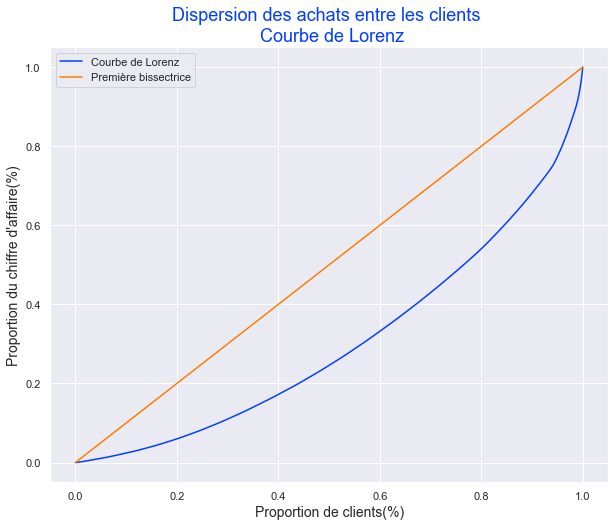

In [75]:
n = len(fichier_global_part['ca'])
lorenz = np.cumsum(np.sort(fichier_global_part['ca'])) / fichier_global_part['ca'].sum()
lorenz = np.append([0],lorenz)

xaxis = np.linspace(0-1/n,1+1/n,len(lorenz))

plt.figure(figsize = (10,8))
plt.title("Dispersion des achats entre les clients \n Courbe de Lorenz", fontsize=18,color='b')
plt.plot(xaxis,lorenz,drawstyle='steps-post',label="Courbe de Lorenz")
plt.plot([0,1], [0,1],label="Première bissectrice")
plt.ylabel("Proportion du chiffre d'affaire(%)",fontsize=14)
plt.xlabel("Proportion de clients(%)",fontsize=14)
plt.legend(loc="upper left")
plt.show()

> Nous pouvons conclure de cette courbe que les achats entre les différents clients ne se font pas de manière égalitaire. 80% des clients ne genèrent qu'environ 55% du CA. Cela signifie que les 20% restant génèrent 45% du CA. 

+ Calcul de l'indice de Gini qui va mesurer l'aire entre la courbe de Lorenz et la première bissectrice

In [76]:
AUC = (lorenz.sum() - lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini = round(2*S,4)
gini

0.3928

> L'indice de Gini nous confirme la répartition inégalitaire du CA généré par client. Plus l'indice de Gini est proche de zéro, plus la répartition sera égalitaire. 

#### Analyse sur le genre des clients<a class="anchor" id="ca_genre"></a>

In [77]:
# Chiffre d'affaire moyen selon le genre

fichier_global_ca_genre = round(fichier_global_part.groupby(['sex'])['ca'].mean().reset_index(),2)
fichier_global_ca_genre 

,sex,ca
0,f,17.34
1,m,17.35


> On peut dire de ce résultat que quelque soit le genre, le panier moyen par achat est similaire.

In [78]:
# On peut se demander le ratio de femmes et d'hommes dans nos clients

nb_vente_genre = fichier_global_part['sex'].value_counts()
nb_vente_genre

f    328811
m    303105
Name: sex, dtype: int64

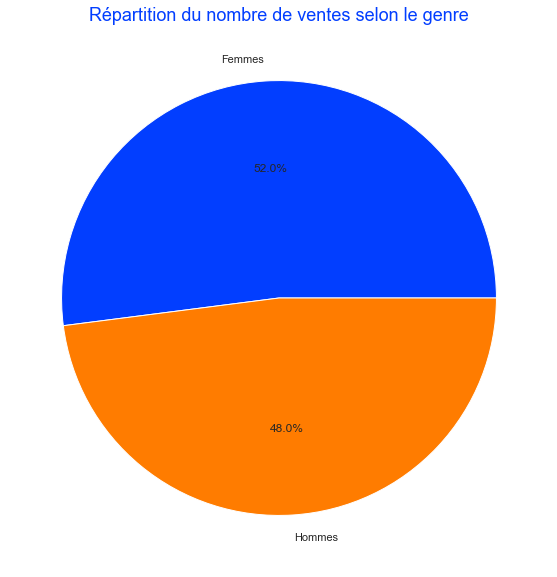

In [79]:
plt.figure(figsize = (10,10))
plt.title("Répartition du nombre de ventes selon le genre", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
plt.pie(x=nb_vente_genre,labels = ['Femmes','Hommes'],autopct='%.1f%%')
plt.show()

> Les femmes achètent davantage de livres que les hommes

In [80]:
# Regardons maintenant le CA total selon le genre. On s'attend naturellement à ce qu'il soit plus important pour les femmes.

fichier_global_ca_sum_genre = round(fichier_global_part.groupby(['sex'])['ca'].sum().reset_index(),2)
fichier_global_ca_sum_genre

,sex,ca
0,f,5700307.13
1,m,5259259.33


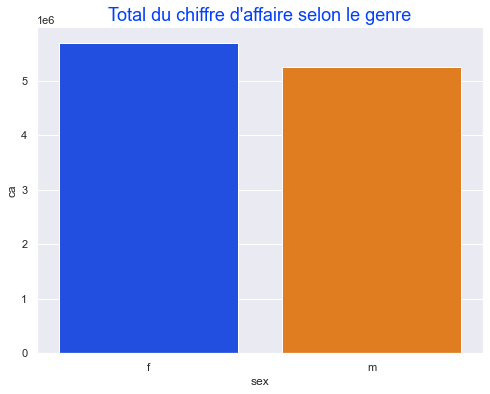

In [81]:
plt.figure(figsize = (8,6))
plt.title("Total du chiffre d'affaire selon le genre", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
sns.barplot(data=fichier_global_ca_sum_genre, x="sex", y="ca")
plt.show()

> Les femmes génèrent un chiffre d'affaire plus important que celui généré par les hommes.

#### Analyse sur l'âge des clients<a class="anchor" id="ca_age"></a>

In [82]:
# J'ajoute une colonne 'âge des clients'

fichier_global_part['age'] = 2022 - fichier_global_part['birth']
fichier_global_part.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois,age
400775,c_1769,m,1996,1_468,2021-03,s_125,17.75,1.0,2021,3,1,1,26
476277,c_3779,f,1990,0_1448,2021-03,s_382,18.94,0.0,2021,3,1,1,32
47281,c_2505,f,1982,0_1571,2021-03,s_12,5.99,0.0,2021,3,1,1,40
237001,c_5212,f,1979,0_1583,2021-03,s_246,15.99,0.0,2021,3,1,1,43
174982,c_4730,m,1955,1_286,2021-03,s_265,29.44,1.0,2021,3,1,1,67


In [83]:
# Je discrétise ma variable âge en 7 tranches d'âge

def trancheAge(age) :
    if age < 25 :
        return '15'
    elif 24 < age < 35 :
        return '25'
    elif 34 < age < 45 :
        return '35'
    elif 44 < age < 55 :
        return '45'
    elif 54 < age < 65 :
        return '55'
    elif 64 < age < 75 :
        return '65'
    elif 74 < age < 85 :
        return '75'
    
fichier_global_part['tranche_age'] = fichier_global_part['age'].apply(trancheAge)
fichier_global_part.sort_values(['tranche_age'],inplace=True)
fichier_global_part.head()

,client_id,sex,birth,id_prod,date,session_id,ca,categ,annee,mois,jour,quart_mois,age,tranche_age
252933,c_1669,m,2004,1_417,2021-05,s_28490,20.99,1.0,2021,5,1,1,18,15
47763,c_6068,m,2001,2_13,2021-10,s_99761,50.99,2.0,2021,10,4,1,21,15
125023,c_1237,f,1999,1_403,2022-12,s_306605,17.99,1.0,2022,12,3,1,23,15
672832,c_6031,m,2003,0_1527,2022-12,s_306589,7.99,0.0,2022,12,3,1,19,15
219453,c_2493,f,1998,2_163,2022-05,s_212433,68.99,2.0,2022,5,22,3,24,15


In [84]:
# Je convertis ma variable au format numérique.

fichier_global_part['tranche_age'] = pd.to_numeric(fichier_global_part['tranche_age'],errors='coerce')

In [85]:
# CA total par tranche d'âge 

ca_par_tranche_age = round(fichier_global_part.groupby(['tranche_age'])['ca'].sum().reset_index(),2)
ca_par_tranche_age

,tranche_age,ca
0,15.0,1715110.72
1,25.0,2292851.57
2,35.0,2780417.66
3,45.0,2013597.14
4,55.0,1104519.42
5,65.0,730472.42
6,75.0,259397.52


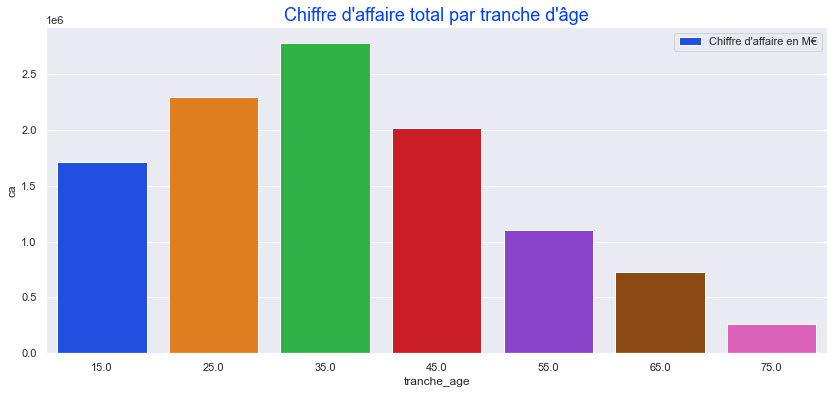

In [86]:
plt.figure(figsize = (14,6))
plt.title("Chiffre d'affaire total par tranche d'âge", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.grid(axis='x')
sns.barplot(data=ca_par_tranche_age, x="tranche_age", y="ca",label = "Chiffre d'affaire en M€")
plt.legend(loc="upper right")
plt.show()

+ Regardons maintenant la proportion des ventes par tranche d'âge

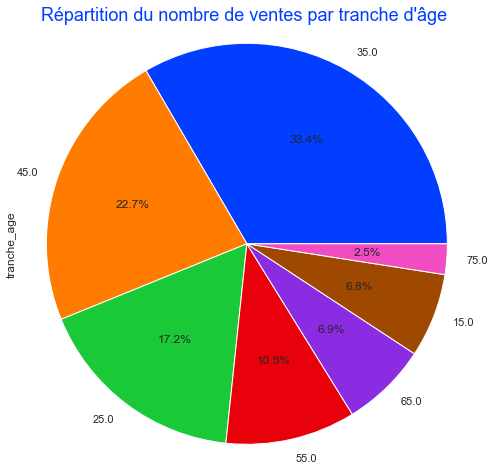

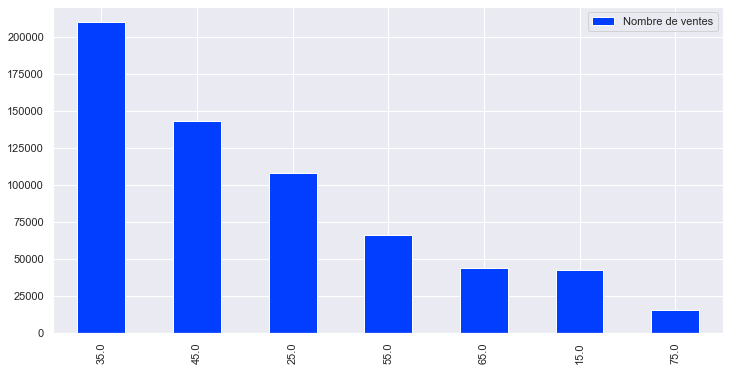

In [87]:
# Diagramme en secteurs
plt.figure(figsize = (8,8))
fichier_global_part['tranche_age'].value_counts().plot(kind='pie',autopct='%.1f%%')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal')
plt.title("Répartition du nombre de ventes par tranche d'âge",fontsize=18,color='b')
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
plt.figure(figsize = (12,6))
fichier_global_part['tranche_age'].value_counts().plot(kind='bar',label='Nombre de ventes')
plt.legend(loc='upper right')
plt.show()

### 2. Correlation entre deux variables : tests statistiques<a class="anchor" id="stats"></a>

#### Genre et Catégorie<a class="anchor" id="genre_categ"></a> : **Correlation entre deux variables qualitatives**

*Formulation de la question :* le genre du client a t-il une influence sur la catégorie des livres achetés ?

*Détermination de H0 et H1 :*

Hypothèse nulle H0 : il n'y a aucun lien entre le genre du client et la catégorie des livres achetés.

Hypothèse alternative H1 : il y a une relation entre le genre et la catégorie. 

*Détermination du test* : étant donné que nous avons à faire à deux variables qualitatives, nous allons pouvoir vérifier une éventuelle correlation entre ces deux variables avec le test de Khi2 qui est un test d'association entre deux variables qualitatives.

*Déterminons le seuil de risque alpha qui sera le seuil de rejet de H0 :* plus on veut limiter le risque de se tromper, plus on doit diminuer alpha.

alpha = 0,05

Si p-value < 0,05  =>  on rejette H0 et on accepte H1 en prenant 5% de risque de se tromper.

In [88]:
# Nous allons commencer par réaliser un tableau de contingence

X = "sex"
Y = "categ"

cont = fichier_global_part[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0.0,1.0,2.0,Total
sex,,,,
f,200659,111199,16953,328811
m,186412,100886,15807,303105
Total,387071,212085,32760,631916


In [89]:
# Calculons maintenant le Khi2, la p-value ainsi que le nombre de degrés de liberté

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print("le khi2 est de",round(st_chi2,2))
print("la p-value est de",round(st_p,5))
print("le nombre de degrés de liberté est de",st_dof)

le khi2 est de 20.3
la p-value est de 0.00245
le nombre de degrés de liberté est de 6


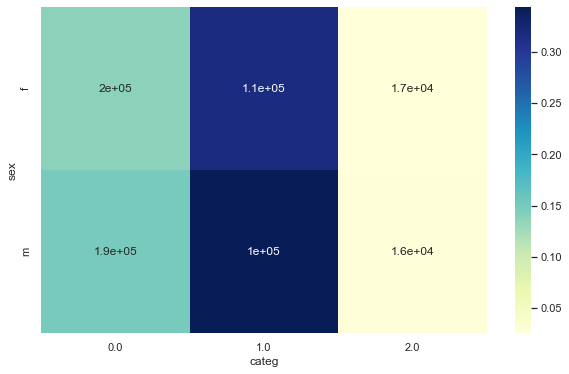

In [90]:
# Représentons maintenant la correlation entre les variables genre et catégorie à l'aide d'une Heatmap

plt.figure(figsize = (10,6))

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(fichier_global_part)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1],cmap = 'YlGnBu')
plt.show()

>En ce qui concerne le resultat du test de Khi2, en considérant un seuil de 5% (0,05) pour la p-value et en se référant à la table de Khi2 (La table donne la probabilité pour que khi2 égale ou dépasse une valeur donnée, en fonction du nombre de degrés de liberté (dans notre cas, 6). 
>On trouve la valeur 12,59. Autrement dit, il y aurait, pour notre tableau 5% de chances que le Khi2 dépasse cette valeur (et 95% de chances qu’il soit inférieur). Une valeur inférieure à 12,59 irait dans le sens d'une indépendance de nos deux variables alors qu'un résultat supérieur irait dans le sens d'une dépendance. 

>Etant donné que le Khi2 calculé est supérieur à cette valeur (20,31) et que la p-value est très inférieure à 5% , nous pouvons considérer que les 2 variables sont correlées (rejet de H0).

Nous allons réaliser un test V de Cramer afin de tester la force de cette association.

Le V de Cramer est compris entre 0 et 1 (inclus). 0 indique que les deux variables ne sont liées par aucune relation. 1 indique qu’il existe une forte association entre les deux variables.

In [91]:
# Test V de Cramer

X2 = st.chi2_contingency(cont, correction=False)[0]
N = np.sum(cont)
minimum_dimension = min(cont.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2/N) / minimum_dimension)
  
# Print the result
print(result)

categ
0.0      0.003621
1.0      0.004891
2.0      0.012445
Total    0.002834
dtype: float64


>Le test V de Cramer donne un résultat pratiquement égal à zéro. 
Nous pouvons donc en conclure que la correlation entre le genre des clients et les catégories de livres achetés est extremement faible.

#### Age et montant total<a class="anchor" id="age_montant_total"></a> : deux variables quantitatives

*Question : l'âge du client a t-il une influence sur le montant total des achats du client ?*

Posons nos hypothèses :

+ Hypothèse H0 = il n'y a pas de relation entre l'âge et le montant total. 
+ Hypothèse alternative H1 = il y a une correlation entre ces deux variables.

Nous avons deux variables quantitatives. Nous allons donc pouvoir effectuer les tests suivants : 

+ Test de rang Spearman : test d'association non paramétrique entre deux variables quantitatives 
+ Test de correlation de Pearson : test d'association paramétrique entre deux variables quantitatives 

Les tests non paramétriques sont plus robustes aux outliers, quand les tests paramétriques sont plus puissants et donnent des résultats plus précis. 
Toutefois les tests paramétriques seront fiables si les valeurs des variables étudiées suivent une distribution normale.

Déterminons le seuil de risque alpha = 0,05

Si p-value < 0,05  =>  on rejette H0 et on accepte H1

In [92]:
# Essayons tout d'abord en agrégeant les données par client et en affichant l'âge de chaque client et le montant total par client.

client_id_ca_total = fichier_global_part.groupby(['client_id','age','tranche_age'])['ca'].sum().reset_index()
client_id_ca_total.rename(columns = {'ca': 'montant_total'}, inplace=True)
client_id_ca_total.sort_values(['tranche_age'],inplace=True)
client_id_ca_total

,client_id,age,tranche_age,montant_total
3277,c_3982,22,15.0,1223.70
7108,c_7472,18,15.0,1361.73
998,c_1906,18,15.0,1167.76
4687,c_5267,23,15.0,804.73
995,c_1903,18,15.0,721.87
...,...,...,...,...
4477,c_5075,82,75.0,237.89
8110,c_8384,83,75.0,1287.33
1289,c_2170,79,75.0,316.44
8134,c_8405,75,75.0,378.83


+ Commençons par regarder si les valeurs des variables 'age' et 'montant_total' suivent une distribution normale avec le test d'Anderson (population > 5000 individus)

Hypothèses :

+ H0 : les valeurs de la variable suivent une distribution normale
+ H1 : les valeurs ne suivent pas une distribution normale.

In [93]:
# Test de normalité d'Anderson Darling appliqué à la variable 'age' du dataframe client_id_ca_total

st.anderson(client_id_ca_total['age'], dist='norm')

AndersonResult(statistic=54.6215442460325, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

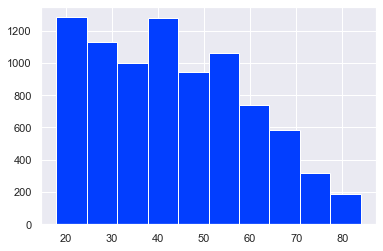

In [94]:
# Regardons graphiquement la distribution de la variable 'age'

client_id_ca_total['age'].hist()
plt.show()

In [95]:
# Regardons la normalité de la variable 'montant_total' du dataframe client_id_ca_total

st.anderson(client_id_ca_total['montant_total'], dist='norm')

AndersonResult(statistic=225.78063028462384, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

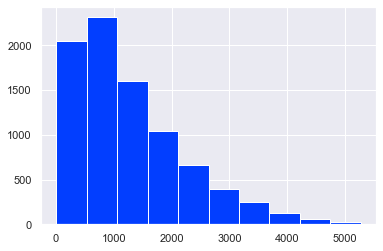

In [96]:
# Regardons graphiquement la distribution de la variable 'montant_total'

client_id_ca_total['montant_total'].hist()
plt.show()

>En regardant les résultats des tests d'Anderson, nous pouvons dire que l’hypothèse nulle est rejetée à tous les niveaux de signification ici dans les deux cas car la statistique de test est supérieure à toutes les valeurs critiques.

>Les valeurs des variables 'age' et 'montant_total' ne suivent donc pas une distribution normale.
>Cela se confirme graphiquement.

>=> Il est donc plus cohérent d'effectuer un test non paramétrique, comme le test de Spearman. 

Le résultat du test de Spearman prend une valeur comprise entre -1 (association négative) et 1 (association positive).
0 signifie qu'il n'y a pas d'association.

In [97]:
from scipy. stats  import spearmanr

# Calcul du coefficient de corrélation de rang Spearman
spearman = spearmanr(client_id_ca_total['age'], client_id_ca_total['montant_total'])[0]
print("le coefficient de correlation de rang Spearman entre l'âge et le montant total est de",round(spearman,4))

le coefficient de correlation de rang Spearman entre l'âge et le montant total est de -0.1809


In [98]:
#extraire la p-value du coefficient de corrélation de rang Spearman 
spearmanp = round(spearmanr(client_id_ca_total['age'], client_id_ca_total['montant_total'])[1],5)
print("la p-value du coefficient de correlation de rang spearman est de",spearmanp)

la p-value du coefficient de correlation de rang spearman est de 0.0


>Une p-value de 0 nous indique que nous pouvons rejeter H0. Il y aurait donc une corrélation entre l'âge et le montant total.

>Un coefficient de spearman de -0,18 indique une faible corrélation négative. 
C'est à dire que plus l'âge augmente, plus le montant total diminue. 

Regardons si on obtenons les mêmes résultats avec le test de Pearson.

In [99]:
# Calculons le coefficient de Pearson et la covariance

pearson = round(st.pearsonr(client_id_ca_total["age"],client_id_ca_total["montant_total"])[0],4)
cov = round(np.cov(client_id_ca_total["age"],client_id_ca_total["montant_total"],ddof=0)[1,0],4)
print("Le coefficient de Pearson est de",pearson)
print("La covariance est de",cov)

Le coefficient de Pearson est de -0.1837
La covariance est de -2887.1804


>Le coefficient de Pearson donne le même résutat => faible corrélation négative

Apprécions cette corrélation visuellement avec un graphique

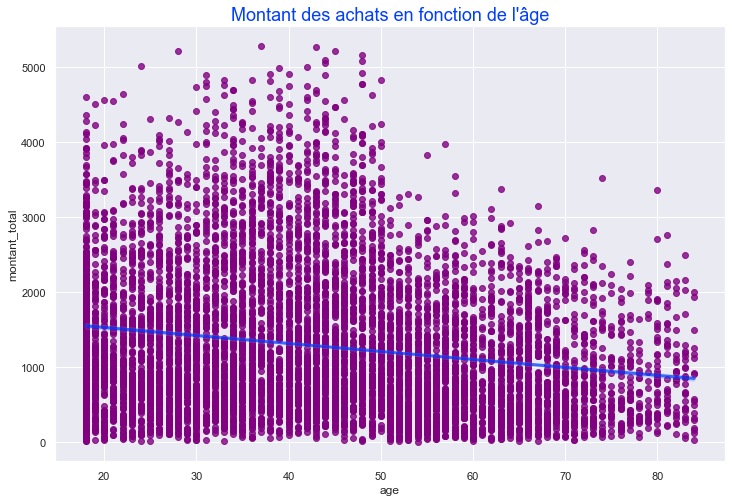

In [100]:
plt.figure(figsize = (12,8))
plt.title("Montant des achats en fonction de l'âge", fontsize=18,color='b')
plt.xlabel("age")
plt.ylabel("montant des achats")
sns.regplot(x=client_id_ca_total['age'], y=client_id_ca_total['montant_total'], marker='o', color='purple', line_kws={"color":"b","alpha":0.7,"lw":3})
plt.show()

>La représentation graphique du montant total en fonction de l'âge nous montre effectivement une corélation négative. 
On retrouve bien une diminution du montant total en fonction de l'avancée de l'âge.

In [101]:
# Essayons maintenant de refaire les tests en agrégeant les données par âge et en affichant le montant total par âge.

age_ca_total = client_id_ca_total.groupby(['age','tranche_age'])['montant_total'].sum().reset_index()
age_ca_total.head()

,age,tranche_age,montant_total
0,18,15.0,608102.98
1,19,15.0,177611.80
2,20,15.0,183869.09
3,21,15.0,178332.76
4,22,15.0,164619.20


In [102]:
# Calcul du coefficient de corrélation de rang Spearman et de la p-value associée.

spearman = spearmanr(age_ca_total['age'], age_ca_total['montant_total'])[0]
spearmanp = round(spearmanr(age_ca_total['age'], age_ca_total['montant_total'])[1],5)
print("le coefficient de correlation de rang Spearman entre l'âge et le montant total est de",round(spearman,4))
print("la p-value du coefficient de correlation de rang spearman est de",spearmanp)

le coefficient de correlation de rang Spearman entre l'âge et le montant total est de -0.816
la p-value du coefficient de correlation de rang spearman est de 0.0


>Une p-value de 0 nous indique que nous pouvons rejeter H0 et accepter H1. Il y a une donc une correlation entre les variables âge et montant total.

>Le test de rang Spearman a un résultat proche de -1. Il indique donc une correlation négative forte entre l'âge des clients et le montant total.

Regardons si on obtenons les mêmes résultats avec le test de Pearson.

In [103]:
# Calculons le coefficient de Pearson et la covariance

pearson = round(st.pearsonr(age_ca_total["age"],age_ca_total["montant_total"])[0],4)
cov = round(np.cov(age_ca_total["age"],age_ca_total["montant_total"],ddof=0)[1,0],4)
print("Le coefficient de Pearson est de",pearson)
print("La covariance est de",cov)

Le coefficient de Pearson est de -0.7824
La covariance est de -1610932.2594


>Le coefficient de correlation de Pearson est négatif et proche de -1. Cela signifie qu'il y a une forte correlation entre l'âge et le montant total des achats et que cette correlation est négative, c'est à dire que plus l'âge augmente, plus le chiffre d'affaire généré diminue. 

+ Représentation graphique du montant total en fonction de l'age (agrégé)

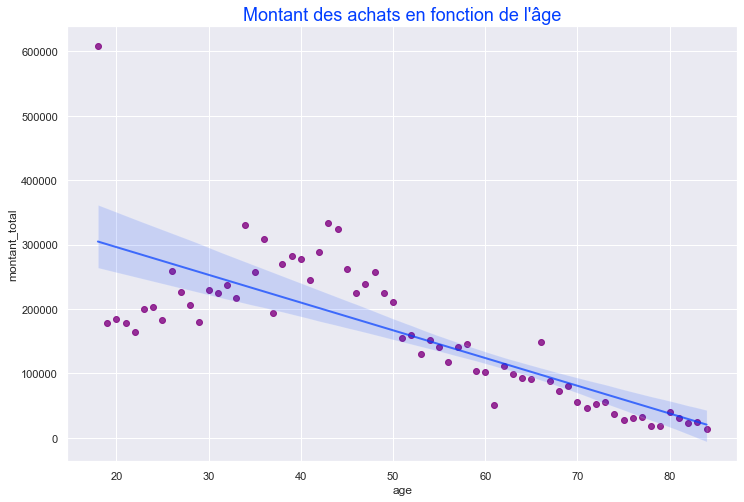

In [104]:
plt.figure(figsize = (12,8))

plt.title("Montant des achats en fonction de l'âge", fontsize=18,color='b')
plt.xlabel("age")
plt.ylabel("montant des achats")
sns.regplot(x=age_ca_total['age'],y=age_ca_total['montant_total'], color='purple', line_kws={"color":"b","alpha":0.7,"lw":2})
plt.show()

>Nous constatons qu'en agrégeant les données par âge, les variables sont liées avec une association plus forte. La correlation négative est plus marquée. Le graphique montre une augmentation du montant total des achats jusqu'à 45 ans puis ensuite il diminue.

>Ce scatterplot nous permet aussi de mettre en évidence un outlier : clients de 18 ans générant plus de 600 000€ de chiffre d'affaire. 

#### Tranche d'âge et montant total<a class="anchor" id="tranche_age_montant_total"></a> : Correlation entre une variable qualitative et une variable quantitative

Regardons si nous obtenons les mêmes résultats en utilsant la variable qualitative 'tranche_age' à la place de la variable quantitative 'age'.

Nous allons pouvoir tester la correlation avec Anova.

L'anova est l'analyse de la variance. Elle permet d'étudier le comportement d'une variable quantitative en fonction d'une ou de plusieurs variables qualitatives. C'est un test de comparaison des moyennes de plusieurs variables.

L'eta-squared permet de mesurer la taille de l'effet (du lien) entre les variables. 

Les règles sont les suivantes :
+ 0.01: Petite taille d’effet
+ 0.06: Taille moyenne de l’effet
+ 0.14 ou supérieur : Grande taille d’effet

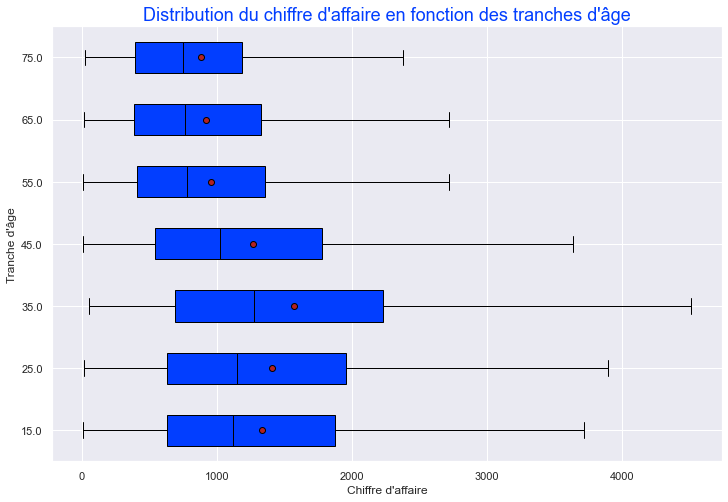

In [105]:
X = "tranche_age" # qualitative
Y = "montant_total" # quantitative

plt.figure(figsize = (12,8))
plt.title("Distribution du chiffre d'affaire en fonction des tranches d'âge", fontsize=18,color='b')
modalites = client_id_ca_total[X].unique()
groupes = []
for m in modalites:
    groupes.append(client_id_ca_total[client_id_ca_total[X]==m][Y])

# Propriétés graphiques    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Tranche d'âge")
plt.xlabel("Chiffre d'affaire")
plt.show()

>On constate une différence des moyennes. Les moyennes des montants sont plus élevées pour les tranches d'âge jusqu'à 55 ans. Les montants sont aussi plus dispersés pour les moins de 55 ans. 

In [106]:
x = "tranche_age" # qualitative
y = "montant_total" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(client_id_ca_total[X],client_id_ca_total[Y])

0.05823719126959833

>L'eta-squared qui mesure la taille de l'effet entre les variables âge et catégorie de livres achetés va dans le sens d'une taille moyenne de l'effet.

Testons maintenant la correlation entre les variables âge et catégorie avec le test de Kruskal-Wallis

+ L’hypothèse nulle (H0) : La médiane est la même pour tous les groupes de données = absence de différence
+ L’hypothèse alternative : (H1) : La médiane n’est pas égale pour tous les groupes de données = il y a une différence

In [107]:
# Test de Kruskal-Wallis

kruskal_wallis = st.kruskal(client_id_ca_total['tranche_age'],client_id_ca_total['montant_total'])
print(kruskal_wallis)

KruskalResult(statistic=12619.8273987018, pvalue=0.0)


>La p-value est égale à zéro. Nous pouvons rejeter l'hypothèse nulle et donc parler de différence significative entre les médianes des différents groupes => il y a bien une correlation entre les variables tranche_age et montant_total.

#### Panier moyen par âge<a class="anchor" id="age_panier_moyen"></a> : corrélation entre deux variables quantitatives

*Question : l'âge a t-il une influence sur la taille du panier moyen ?*

Posons nos hypothèses : 

+ H0 : il n'y a pas de correlation entre l'âge et le montant du panier moyen
+ H1 : il y a une relation entre l'âge et le montant du panier moyen

Nous avons à nouveau à faire à deux variables quantitatives. Nous allons donc pouvoir effectuer les tests suivants : 

+ Test de rang Spearman 
+ Test de correlation de Pearson 

Déterminons le seuil de risque alpha = 0,05

Si p-value < 0,05  =>  on rejette H0 et on accepte H1

In [108]:
# Allons chercher nos données

panier_moyen_par_age = round(fichier_global_part.groupby(['client_id','age','tranche_age'])['ca'].mean().reset_index(),2)
panier_moyen_par_age.rename(columns = {'ca': 'panier_moyen'}, inplace=True)
panier_moyen_par_age.sort_values(['tranche_age'],inplace=True)   
panier_moyen_par_age.head()

,client_id,age,tranche_age,panier_moyen
3277,c_3982,22,15.0,21.10
7108,c_7472,18,15.0,52.37
998,c_1906,18,15.0,48.66
4687,c_5267,23,15.0,30.95
995,c_1903,18,15.0,34.37


+ Commençons par tester la normalité de la variable 'panier_moyen'

Hypothèses :

+ H0 : les valeurs de la variable 'panier_moyen' suivent une distribution normale
+ H1 : les valeurs de la variable 'panier_moyen' ne suivent pas une distribution normale

In [109]:
# Test d'Anderson

st.anderson(panier_moyen_par_age['panier_moyen'], dist='norm')

AndersonResult(statistic=991.0295805709266, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

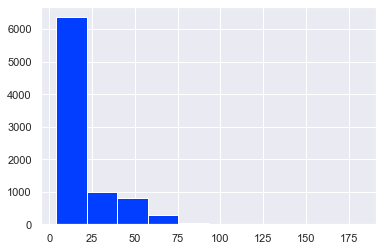

In [110]:
# Regardons graphiquement la distribution de la variable panier_moyen

panier_moyen_par_age['panier_moyen'].hist()
plt.show()

>Le résultat du test de normalité Anderson Darling est supérieur à toutes les valeurs critiques. Nous pouvons rejeter H0.
Les valeurs de la variable 'panier_moyen' ne suivent donc pas une distribution normale. Cela se confirme graphiquement.

>Le test le plus adapté sera donc le test de Spearman (non paramétrique).

In [111]:
# Test de Spearman

spearman = spearmanr(panier_moyen_par_age ['age'], panier_moyen_par_age ['panier_moyen'])[0]
spearmanp = spearmanr(panier_moyen_par_age ['age'], panier_moyen_par_age['panier_moyen'])[1]
print("le coefficient de correlation de rang Spearman entre l'âge et la fréquence d'achat est de",round(spearman,4))
print("la Pvalue du coefficient de correlation derang spearman est de",round(spearmanp,4))

le coefficient de correlation de rang Spearman entre l'âge et la fréquence d'achat est de -0.3315
la Pvalue du coefficient de correlation derang spearman est de 0.0


>La p-value est de 0. Elle va donc dans le sens d'une correlation.

>Le test de Spearman va également dans ce sens d'une correlation négative. 

Vérifions cela avec le test de Pearson.

In [112]:
# Test de Pearson

pearson = round(st.pearsonr(panier_moyen_par_age['age'],panier_moyen_par_age ['panier_moyen'])[0],4)
cov = round(np.cov(panier_moyen_par_age['age'],panier_moyen_par_age ['panier_moyen'],ddof=0)[1,0],4)
print("Le coefficient de Pearson est de",pearson)
print("La covariance est de",cov)

Le coefficient de Pearson est de -0.5209
La covariance est de -129.2537


>Le test de Pearson montre également une correlation négative. C'est à dire que plus l'âge augmente et plus le montant du panier moyen diminue. 

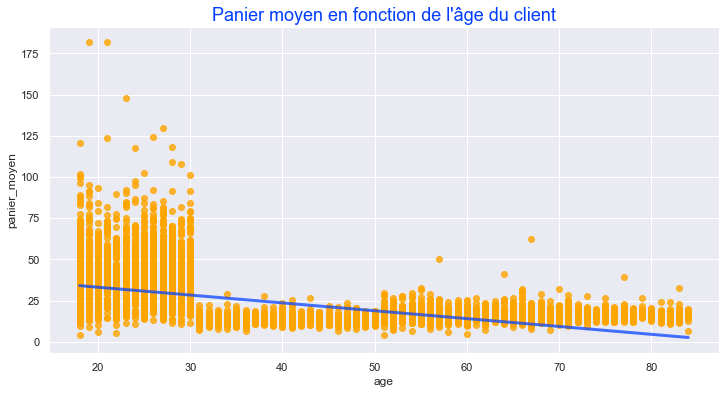

In [113]:
# Regardons cela avec une représentation graphique

plt.figure(figsize = (12,6))
plt.title("Panier moyen en fonction de l'âge du client", fontsize = 18,color='b')
plt.xlabel("age")
plt.ylabel("montant du panier moyen")
sns.regplot(x = panier_moyen_par_age['age'], y = panier_moyen_par_age['panier_moyen'], color='orange',line_kws={"color":"b","alpha":0.7,"lw":3})
plt.show()

>En visualisant les résultats de manière graphique, nous remarquons effectivement la correlation négative. 
Le panier moyen est plus important chez les clients jusqu'à 30 ans. Ensuite il diminue.

>#### Panier moyen par tranche d'âge<a class="anchor" id="tranche_age_panier_moyen"></a> : Anova

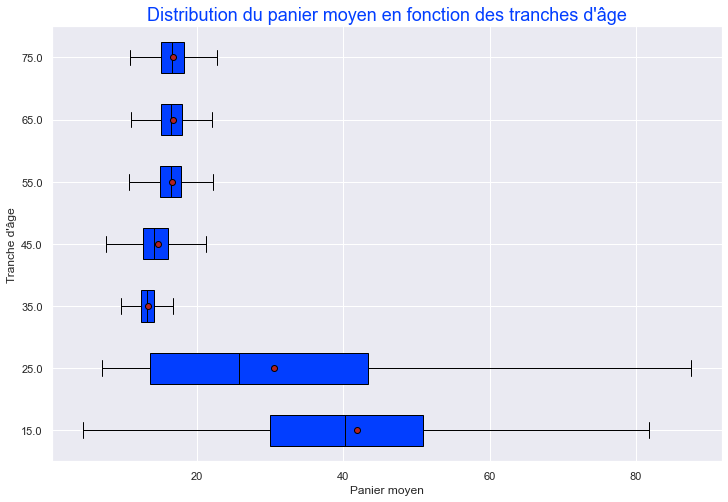

L'eta-squared est de 0.46755122941896887


In [114]:
# Regardons maintenant ce que donne la corrélation par Anova entre les variables tranche_age (qualitative)
# et panier_moyen (quantitative)

X = "tranche_age" # qualitative
Y = "panier_moyen" # quantitative

plt.figure(figsize = (12,8))
plt.title("Distribution du panier moyen en fonction des tranches d'âge", fontsize=18,color='b')
modalites = panier_moyen_par_age[X].unique()
groupes = []
for m in modalites:
    groupes.append(panier_moyen_par_age[panier_moyen_par_age[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Tranche d'âge")
plt.xlabel("Panier moyen")
plt.show()

print("L'eta-squared est de", eta_squared(panier_moyen_par_age[X],panier_moyen_par_age[Y]))

En analysant la corrélation tranche_age et panier_moyen, on retrouve des moyennes et des dispersion de panier moyen beaucoup plus élevées pour les jeunes de moins de 35 ans.
L'eta-squared montre une taille importante du lien.

Testons maintenant la correlation entre les variables âge et catégorie avec le test de Kruskal-Wallis

+ L’hypothèse nulle (H0) : La médiane est la même pour tous les groupes de données = absence de différence
+ L’hypothèse alternative : (H1) : La médiane n’est pas égale pour tous les groupes de données = il y a une différence

In [115]:
# Kruskall-Wallis

kruskal_wallis = st.kruskal(panier_moyen_par_age['tranche_age'],panier_moyen_par_age['panier_moyen'])
print(kruskal_wallis)

KruskalResult(statistic=4824.454083434169, pvalue=0.0)


>La p-value est égale à zéro. Nous pouvons rejeter l'hypothèse nulle et donc parler de différence significative entre les médianes des différents groupes => il y a bien une correlation entre les variables tranche_age et panier-moyen. 

#### Age des clients et fréquence d'achats<a class="anchor" id="age_frequence_achat"></a> : deux variables quantitatives

*Question : l'âge du client a t-il une influence sur la fréquence des achats ?*

Posons nos hypothèses :
+ H0 : il n'y a pas de relation entre l'âge des clients et la fréquence d'achat
+ H1 : l'âge des clients a une influence sur la fréquence des achats

Nous avons à nouveau à faire à deux variables quantitatives. Nous allons donc pouvoir effectuer les tests suivants : 

+ Test de rang Spearman 
+ Test de correlation de Pearson 

Déterminons le seuil de risque alpha = 0,05

Si p-value < 0,05  =>  on rejette H0 et on accepte H1

In [116]:
# Regardons le nombre d'achats par client sur la période totale

frequence_achats = fichier_global_part.groupby(['client_id','age','tranche_age'])['session_id'].count().reset_index()
frequence_achats.rename(columns = {'session_id': 'frequence_achats'}, inplace=True)
frequence_achats.sort_values(['tranche_age'],inplace=True)
frequence_achats.head()

,client_id,age,tranche_age,frequence_achats
3277,c_3982,22,15.0,58
7108,c_7472,18,15.0,26
998,c_1906,18,15.0,24
4687,c_5267,23,15.0,26
995,c_1903,18,15.0,21


In [117]:
# Testons la normalité sur la variable fréquence d'achat par client. 
# H0 : les valeurs de la variable 'fréquence_achats' suivent une distribution normale
# H1 : les valeurs de la variable 'fréquence_achats' ne suivent pas une distribution normale

st.anderson(frequence_achats['frequence_achats'], dist='norm')

AndersonResult(statistic=471.6848178277887, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

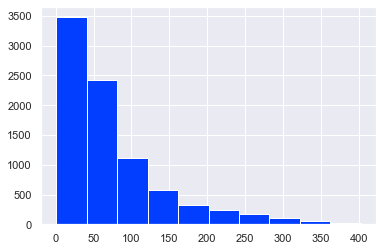

In [118]:
# Regardons graphiquement la distribution de la variable 'frequence_achat'

frequence_achats['frequence_achats'].hist()
plt.show()

>Le résultat du test de normalité Anderson Darling est supérieur à toutes les valeurs critiques
Nous pouvons donc rejeter H0.
Les valeurs de la variable 'frequence_achats' ne suivent pas une distribution normale. 
Cela se confirme graphiquement.

>Le test le plus adapté sera donc encore une fois le test de Spearman (non paramétrique).

In [119]:
# Test de Spearman

spearman = spearmanr(frequence_achats['age'], frequence_achats['frequence_achats'])[0]
spearmanp = spearmanr(frequence_achats['age'], frequence_achats['frequence_achats'])[1]
print("le coefficient de correlation de rang Spearman entre l'âge et la fréquence d'achat est de",round(spearman,4))
print("la Pvalue du coefficient de correlation derang spearman est de",round(spearmanp,4))

le coefficient de correlation de rang Spearman entre l'âge et la fréquence d'achat est de 0.1353
la Pvalue du coefficient de correlation derang spearman est de 0.0


>La valeur du coefficient de rang Spearman et sa p-value associée montrerait une faible correlation positive entre les deux variables.

In [120]:
# Nous pouvons effectuer le test de Pearson

pearson = round(st.pearsonr(frequence_achats['age'],frequence_achats['frequence_achats'])[0],4)
cov = round(np.cov(frequence_achats['age'],frequence_achats['frequence_achats'],ddof=0)[1,0],4)
print("Le coefficient de Pearson est de",pearson)
print("La covariance est de",cov)

Le coefficient de Pearson est de 0.0398
La covariance est de 44.5431


>Le coefficient de Pearson étant proche de zéro, il est en faveur d'une absence de relation.
>Toutefois étant donné que le test de Pearson est un test paramétrique réservé aux distributions linéaires, nous pouvons dire aussi qu'un résultat proche de zéro montre une absence de corrélation linéaire.

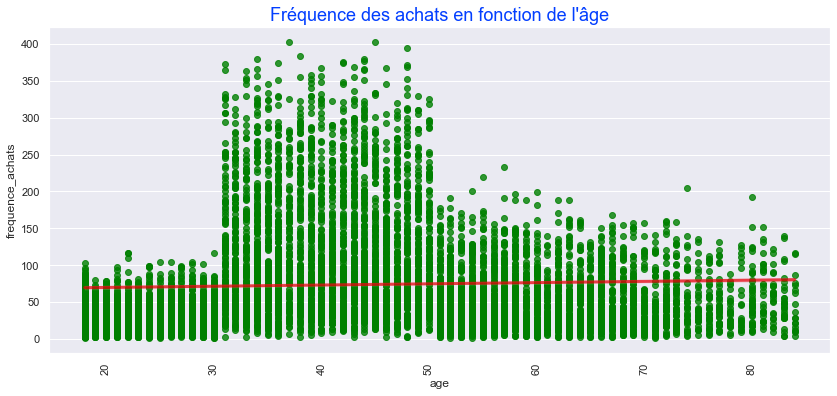

In [121]:
# Regardons cela avec la représentation graphique de la fréquence d'achats en fonction de l'âge

plt.figure(figsize = (14,6))
plt.title("Fréquence des achats en fonction de l'âge", fontsize=18,color='b')
sns.set_theme(palette="bright")
plt.xticks([20,30,40,50,60,70,80])
plt.xticks(rotation='vertical')
plt.grid(axis='x')
sns.regplot(x=frequence_achats["age"], y=frequence_achats["frequence_achats"],color='green',line_kws={"color":"r","alpha":0.7,"lw":3})
plt.show()

>Graphiquement, on voit que les clients de 30 à 50 ans font des achats plus fréquents que les clients de moins de 30 ans ou de plus de 50 ans. Il y a donc bien une corrélation.

>Toutefois, la droite de regression linéaire est pratiquement à l'horizontale, d'où les résultats des tests, qui ne penchent ni pour une corrélation positive, ni pour une correlation négative. Graphiquement, il apparaît tout de même une corrélation mais elle n'est pas linéaire.

#### Tranche d'âge des clients et fréquence d'achats<a class="anchor" id="tranche_age_frequence_achat"></a> : Anova

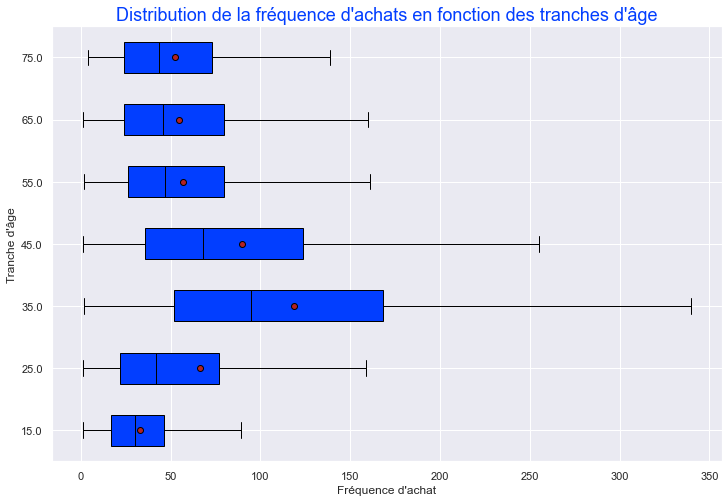

L'eta-squared est de  0.1753046713738403


In [122]:
# Regardons maintenant ce que donne la corrélation par Anova entre les variables tranche_âge (qualitative) et frequence_achats (quantitative)

X = "tranche_age" # qualitative
Y = "frequence_achats" # quantitative

plt.figure(figsize = (12,8))
plt.title("Distribution de la fréquence d'achats en fonction des tranches d'âge", fontsize=18,color='b')
modalites = frequence_achats[X].unique()
groupes = []
for m in modalites:
    groupes.append(frequence_achats[frequence_achats[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Tranche d'âge")
plt.xlabel("Fréquence d'achat")
plt.show()

print("L'eta-squared est de ",eta_squared(frequence_achats[X],frequence_achats[Y]))

>On retrouve des moyennes plus élevées pour les tranches d'âge 35 et 45 ans, ainsi que des dispersions de fréquence d'achat plus importantes. 

>L'eta-squared va dans le sens d'une grande taille de l'effet.

Testons maintenant la correlation entre les variables âge et catégorie avec le test de Kruskal-Wallis

+ L’hypothèse nulle (H0) : La médiane est la même pour tous les groupes de données = absence de différence
+ L’hypothèse alternative : (H1) : La médiane n’est pas égale pour tous les groupes de données = il y a une différence

In [123]:
# Effectuons le test de Kruskal-Wallis

kruskal_wallis = st.kruskal(frequence_achats['tranche_age'],frequence_achats['frequence_achats'])
print(kruskal_wallis)

KruskalResult(statistic=963.8243559081981, pvalue=1.311269722724074e-211)


>La p-value est pratiquement égale à zéro (exposant négatif). Nous pouvons donc rejeter l'hypothèse nulle et considérer qu'il y a une différence significative entre les médianes des groupes de données => il y a bien une influence de la tranche d'âge sur la fréquence d'achat.

#### Catégorie des livres achetés par tranche d'âge<a class="anchor" id="tranche_age_categ"></a> : Correlation entre deux variables qualitatives

*Question : la tranche d'âge a t'il un effet sur la catégorie des livres achetés ?*

Posons nos hypothèses : 

+ H0 : il n'y a pas de relation entre la tranche d'âge et la catégorie de livres achetés.
+ H1 : il y a une relation.

Nous avons à faire à deux variables qualitatives, nous allons pouvoir vérifier une éventuelle correlation entre ces deux variables avec le test de Khi2.

Déterminons le seuil de risque alpha = 0,05

Si p-value < 0,05  =>  on rejette H0 et on accepte H1.

In [124]:
# Nous allons commencer par réaliser un tableau de contingence

X = "tranche_age"
Y = "categ"

conting = fichier_global_part[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
conting

categ,0.0,1.0,2.0,Total
tranche_age,,,,
15.0,9578,16019,16990,42587
25.0,65272,29540,13126,107938
35.0,159329,49689,770,209788
45.0,96983,45233,683,142899
55.0,28789,36477,612,65878
65.0,18749,24489,371,43609
75.0,6725,8564,169,15458
Total,385425,210011,32721,628157


In [125]:
# Calculons maintenant le Khi2, la p-value ainsi que le nombre de degrés de liberté

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(conting)
print("le khi2 est de",round(st_chi2,2))
print("la p-value est de",round(st_p,5))
print("le nombre de degrés de liberté est de",st_dof)

le khi2 est de 179635.06
la p-value est de 0.0
le nombre de degrés de liberté est de 21


>En ce qui concerne le resultat du test de Khi2, en considérant un seuil de 5% (0,05) pour la p-value et en se référant à la table de Khi2 (La table donne la probabilité pour que khi2 égale ou dépasse une valeur donnée, en fonction du nombre de degrés de liberté (dans notre cas, 21). On trouve la valeur 32,67. Autrement dit, il y aurait, pour notre tableau 5% de chances que le Khi2 dépasse cette valeur (et 95% de chances qu’il soit inférieur). Etant donné que le Khi2 calculé est largement supérieur à cette valeur (182060,36), et que la p-value associée est égale à zéro, nous pouvons considérer que les 2 variables sont correlées (rejet de H0).

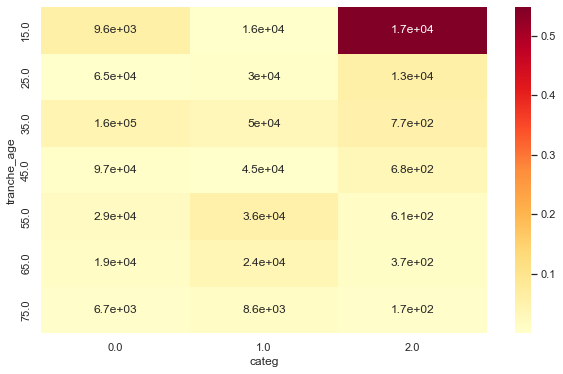

In [126]:
# Représentons maintenant la correlation entre les variables tranche d'âge et catégorie à l'aide d'une Heatmap

plt.figure(figsize = (10,6))

tx = conting.loc[:,["Total"]]
ty = conting.loc[["Total"],:]
n = len(fichier_global_part)
indep = tx.dot(ty) / n

c = conting.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], cmap = 'YlOrRd')
plt.show()

>La heatmap montre une correlation forte pour la tranche d'âge 15-24 et la catégorie 2.

In [127]:
# Regardons avec le Test V de Cramer

X2 = st.chi2_contingency(conting, correction=False)[0]
N = np.sum(conting)
minimum_dimension = min(conting.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2/N) / minimum_dimension)
  
# Print the result
print(result)

categ
0.0      0.278708
1.0      0.377571
2.0      0.956548
Total    0.218316
dtype: float64


>Le résultat du test V de Cramer montre une petite correlation entre les variables tranche d'âge et catégorie des livres achetés. Cela se confirme en effet sur la heatmap (il n'y a qu'une case sur les 27 représentées montrant une correlation importante).

#### Catégorie des livres achetés par âge<a class="anchor" id="age_categ"></a> : relation entre une variable quantitative et une variable qualitative.

Nous allons pouvoir tester la corrrelation avec Anova.

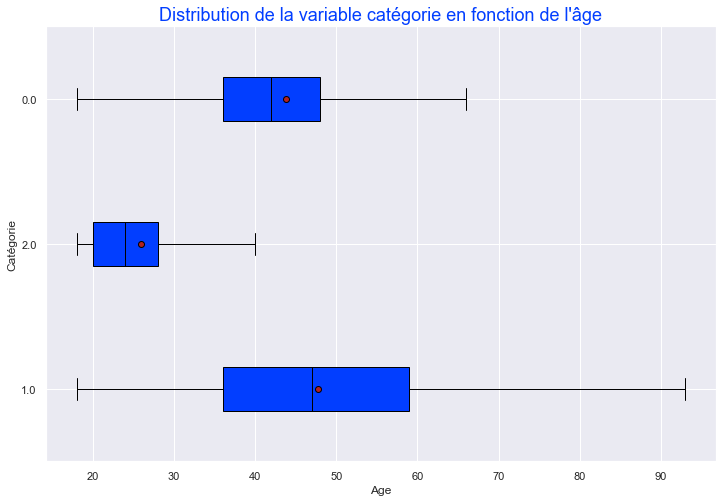

L'eta-squared est de 0.11305181187727019


In [128]:
X = "categ" # qualitative
Y = "age" # quantitative

plt.figure(figsize = (12,8))
plt.title("Distribution de la variable catégorie en fonction de l'âge", fontsize=18,color='b')
modalites = fichier_global_part[X].unique()
groupes = []
for m in modalites:
    groupes.append(fichier_global_part[fichier_global_part[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Catégorie")
plt.xlabel("Age")
plt.show()

print("L'eta-squared est de",eta_squared(fichier_global_part[X],fichier_global_part[Y]))

>Il y a une disparité entre les moyennes des trois groupes. Il y a donc bien une corrélation entre l'âge et la catégorie.

>L'eta-squared qui mesure la taille de l'effet entre les variables âge et catégorie de livres achetés va dans le sens d'une taille moyenne du lien.

Testons maintenant la correlation entre les variables âge et catégorie avec le test de Kruskal-Wallis

+ L’hypothèse nulle (H0) : La médiane est la même pour tous les groupes de données = absence de différence
+ L’hypothèse alternative : (H1) : La médiane n’est pas égale pour tous les groupes de données = il y a une différence

In [129]:
# Effectuons le test de Kruskal-Wallis

kruskal_wallis = st.kruskal(fichier_global_part['categ'],fichier_global_part['age'])
print(kruskal_wallis)

KruskalResult(statistic=980786.4420844294, pvalue=0.0)


>La p-value est égale à zéro. Nous pouvons rejeter l'hypothèse nulle et donc parler de différence significative entre les médianes des différents groupes. => Il y a bien une corrélation entre les variables âge et catégorie.